In [1]:
%cd /content/drive/MyDrive/Agent

/content/drive/MyDrive/Agent


In [2]:
# !pip install -q prophet scikit-learn xgboost pmdarima

# Load Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from pmdarima import auto_arima

In [4]:
# Load the data
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'])

df = df.set_index('date')

In [5]:
df.head()

,tide_verified,turbidity,wind_speed,ndvi
date,,,,
2024-03-01,1.662727,4.654545,5.858182,0.335371
2024-03-02,1.604167,5.037500,5.418333,0.223780
2024-03-03,1.536522,6.152174,3.642609,0.022109
2024-03-04,1.515000,6.650000,3.644167,0.123293
2024-03-05,1.633333,6.812500,4.422917,0.499132


In [6]:
from sklearn.preprocessing import StandardScaler

# Add after loading the data and before creating lag features
# Standardize the features
scaler = StandardScaler()
features_to_scale = ['tide_verified', 'turbidity', 'wind_speed']

# Create a DataFrame for scaled features
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


In [7]:
df.head()

,tide_verified,turbidity,wind_speed,ndvi
date,,,,
2024-03-01,-1.062036,0.124256,-0.197852,0.335371
2024-03-02,-1.192531,0.332567,-0.353739,0.223780
2024-03-03,-1.343269,0.938903,-0.983079,0.022109
2024-03-04,-1.391228,1.209699,-0.982527,0.123293
2024-03-05,-1.127537,1.298093,-0.706528,0.499132


In [8]:
# Create lagged features (will be used for ML models)
for i in range(1, 8):
    df[f'tide_verified_lag_{i}'] = df['tide_verified'].shift(i)
    df[f'turbidity_lag_{i}'] = df['turbidity'].shift(i)
    df[f'wind_speed_lag_{i}'] = df['wind_speed'].shift(i)
    df[f'ndvi_lag_{i}'] = df['ndvi'].shift(i)

# Split data into train and test (last 20% for testing)
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

train_with_lags = df.iloc[:train_size]
test_with_lags = df.iloc[train_size:]

display(train_with_lags.head())
display(test_with_lags.head())

,tide_verified,turbidity,wind_speed,ndvi,tide_verified_lag_1,turbidity_lag_1,wind_speed_lag_1,ndvi_lag_1,tide_verified_lag_2,turbidity_lag_2,...,wind_speed_lag_5,ndvi_lag_5,tide_verified_lag_6,turbidity_lag_6,wind_speed_lag_6,ndvi_lag_6,tide_verified_lag_7,turbidity_lag_7,wind_speed_lag_7,ndvi_lag_7
date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,-1.062036,0.124256,-0.197852,0.335371,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-02,-1.192531,0.332567,-0.353739,0.223780,-1.062036,0.124256,-0.197852,0.335371,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-03,-1.343269,0.938903,-0.983079,0.022109,-1.192531,0.332567,-0.353739,0.223780,-1.062036,0.124256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-04,-1.391228,1.209699,-0.982527,0.123293,-1.343269,0.938903,-0.983079,0.022109,-1.192531,0.332567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-05,-1.127537,1.298093,-0.706528,0.499132,-1.391228,1.209699,-0.982527,0.123293,-1.343269,0.938903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,tide_verified,turbidity,wind_speed,ndvi,tide_verified_lag_1,turbidity_lag_1,wind_speed_lag_1,ndvi_lag_1,tide_verified_lag_2,turbidity_lag_2,...,wind_speed_lag_5,ndvi_lag_5,tide_verified_lag_6,turbidity_lag_6,wind_speed_lag_6,ndvi_lag_6,tide_verified_lag_7,turbidity_lag_7,wind_speed_lag_7,ndvi_lag_7
date,,,,,,,,,,,,,,,,,,,,,
2024-10-08,2.936882,0.678104,-1.216305,-0.018866,1.802775,0.384696,-0.861731,-0.022883,1.384955,0.071920,...,-0.603305,0.463937,1.052556,-0.265787,-1.536149,0.379857,1.148634,-0.442278,-0.938084,0.241321
2024-10-29,-0.756141,-0.427615,2.121361,0.471844,2.936882,0.678104,-1.216305,-0.018866,1.802775,0.384696,...,-0.512635,0.478882,1.231754,-0.227257,-0.603305,0.463937,1.052556,-0.265787,-1.536149,0.379857
2024-10-30,0.189989,-0.551365,2.045783,0.320408,-0.756141,-0.427615,2.121361,0.471844,2.936882,0.678104,...,-0.345174,0.360104,1.132163,-0.073332,-0.512635,0.478882,1.231754,-0.227257,-0.603305,0.463937
2024-10-31,-0.207404,-0.528700,1.787504,0.465450,0.189989,-0.551365,2.045783,0.320408,-0.756141,-0.427615,...,-0.620730,-0.008602,1.076696,-0.077668,-0.345174,0.360104,1.132163,-0.073332,-0.512635,0.478882
2024-11-01,0.166777,-0.642025,1.365606,0.387027,-0.207404,-0.528700,1.787504,0.465450,0.189989,-0.551365,...,-0.861731,-0.022883,1.384955,0.071920,-0.620730,-0.008602,1.076696,-0.077668,-0.345174,0.360104


# Create Ensemble (ARIMA, SARIMA, Prophet, Random Forest, XGBoost)

In [9]:
# 1. ARIMA Model for NDVI
def train_arima(train_data, test_data):
    # Find best ARIMA parameters using auto_arima
    print("Finding best ARIMA parameters...")
    auto_model = auto_arima(train_data['ndvi'], seasonal=False,
                          trace=True, error_action='ignore', suppress_warnings=True,
                          stepwise=True, max_p=5, max_d=2, max_q=5)

    best_order = auto_model.order
    print(f"Best ARIMA order: {best_order}")

    # Train ARIMA model
    model = ARIMA(train_data['ndvi'], order=best_order)
    results = model.fit()

    # Make predictions
    forecast = results.forecast(steps=len(test_data))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data['ndvi'], forecast))
    mae = mean_absolute_error(test_data['ndvi'], forecast)
    r2 = r2_score(test_data['ndvi'], forecast)

    print(f"ARIMA RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    return forecast, results


In [10]:
# 2. SARIMA Model (Seasonal ARIMA)
def train_sarima(train_data, test_data):
    # Adding seasonal component
    seasonal_order = (1, 1, 1, 7)  # (P,D,Q,s) where s is the seasonality

    model = SARIMAX(train_data['ndvi'],
                   order=(1, 1, 1),  # Use ARIMA order or customize
                   seasonal_order=seasonal_order)
    results = model.fit(disp=False)

    # Make predictions
    forecast = results.forecast(steps=len(test_data))

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data['ndvi'], forecast))
    mae = mean_absolute_error(test_data['ndvi'], forecast)
    r2 = r2_score(test_data['ndvi'], forecast)

    print(f"SARIMA RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    return forecast, results


In [11]:
# 3. Prophet Model
def train_prophet(train_data, test_data):
    # Prepare data for Prophet with proper formatting
    prophet_train = train_data.reset_index()[['date', 'ndvi']].rename(
        columns={'date': 'ds', 'ndvi': 'y'})

    # Handle missing values
    prophet_train = prophet_train.dropna(subset=['y'])

    if len(prophet_train) == 0:
        print("Warning: No valid training data for Prophet after dropping NaNs.")
        return np.array([]), None

    # Create and fit model
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_train)

    # Create future dataframe with proper reset_index
    future = pd.DataFrame({'ds': test_data.reset_index()['date']})

    # Predict
    forecast = model.predict(future)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data['ndvi'], forecast['yhat']))
    mae = mean_absolute_error(test_data['ndvi'], forecast['yhat'])
    r2 = r2_score(test_data['ndvi'], forecast['yhat'])

    print(f"Prophet RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    return forecast['yhat'].values, model


In [12]:
# 4. Random Forest with environmental variables
def train_rf(train_data, test_data):
    # Features and target
    features = [col for col in train_data.columns if col != 'ndvi']
    X_train = train_data[features]
    y_train = train_data['ndvi']
    X_test = test_data[features]

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data['ndvi'], predictions))
    mae = mean_absolute_error(test_data['ndvi'], predictions)
    r2 = r2_score(test_data['ndvi'], predictions)

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"Random Forest RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("\nTop 10 important features:")
    print(feature_importance.head(10))

    return predictions, model


In [13]:
# 5. XGBoost with environmental variables
def train_xgboost(train_data, test_data):
    # Features and target
    features = [col for col in train_data.columns if col != 'ndvi']
    X_train = train_data[features]
    y_train = train_data['ndvi']
    X_test = test_data[features]

    # Train model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data['ndvi'], predictions))
    mae = mean_absolute_error(test_data['ndvi'], predictions)
    r2 = r2_score(test_data['ndvi'], predictions)

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"XGBoost RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("\nTop 10 important features:")
    print(feature_importance.head(10))

    return predictions, model


In [14]:
# Train all models
print("Training ARIMA model...")
arima_pred, arima_model = train_arima(train_df, test_df)

Training ARIMA model...
Finding best ARIMA parameters...
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-69.010, Time=2.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1.919, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.588, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-65.262, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-0.070, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-72.707, Time=1.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-71.892, Time=1.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-42.980, Time=0.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-74.586, Time=1.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-67.257, Time=1.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.568, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-72.670, Time=2.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-72.738, Time=3.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-73.841, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-44.964, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-70.920, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 31.723 seconds
Best ARIMA order: (1, 1, 1)
ARIMA RMSE: 0.2530, MAE: 0.2316, R²: -0.4039


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [15]:
print("\nTraining SARIMA model...")
sarima_pred, sarima_model = train_sarima(train_df, test_df)


Training SARIMA model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA RMSE: 0.2945, MAE: 0.2633, R²: -0.9025


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
print("\nTraining Prophet model...")
prophet_pred, prophet_model = train_prophet(train_df, test_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vpllnzi/3uzp947y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3vpllnzi/a8lou7jj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62997', 'data', 'file=/tmp/tmp3vpllnzi/3uzp947y.json', 'init=/tmp/tmp3vpllnzi/a8lou7jj.json', 'output', 'file=/tmp/tmp3vpllnzi/prophet_model27874hto/prophet_model-20250317022952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:29:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Training Prophet model...


02:29:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 0.2581, MAE: 0.2344, R²: -0.4611


In [17]:
print("\nTraining Random Forest model...")
rf_pred, rf_model = train_rf(train_with_lags, test_with_lags)


Training Random Forest model...
Random Forest RMSE: 0.1934, MAE: 0.1609, R²: 0.1795

Top 10 important features:
                Feature  Importance
0         tide_verified    0.132843
6            ndvi_lag_1    0.095458
23  tide_verified_lag_6    0.057359
21     wind_speed_lag_5    0.053629
11  tide_verified_lag_3    0.042963
30           ndvi_lag_7    0.037520
17     wind_speed_lag_4    0.037037
15  tide_verified_lag_4    0.036873
3   tide_verified_lag_1    0.036403
2            wind_speed    0.035998


In [18]:
print("\nTraining XGBoost model...")
xgb_pred, xgb_model = train_xgboost(train_with_lags, test_with_lags)


Training XGBoost model...
XGBoost RMSE: 0.1860, MAE: 0.1553, R²: 0.2408

Top 10 important features:
                Feature  Importance
21     wind_speed_lag_5    0.098273
24      turbidity_lag_6    0.091426
6            ndvi_lag_1    0.075840
17     wind_speed_lag_4    0.056521
22           ndvi_lag_5    0.051825
23  tide_verified_lag_6    0.040787
13     wind_speed_lag_3    0.034792
8       turbidity_lag_2    0.034573
26           ndvi_lag_6    0.034183
25     wind_speed_lag_6    0.031316


In [19]:
# Create ensemble prediction (simple average)
# Ensure all predictions have the same length
min_length = min(len(arima_pred), len(sarima_pred), len(prophet_pred), len(rf_pred), len(xgb_pred))
ensemble_pred = (arima_pred[:min_length] + sarima_pred[:min_length] +
                prophet_pred[:min_length] + rf_pred[:min_length] + xgb_pred[:min_length]) / 5

# Calculate ensemble metrics
ensemble_rmse = np.sqrt(mean_squared_error(test_df['ndvi'][:min_length], ensemble_pred))
ensemble_mae = mean_absolute_error(test_df['ndvi'][:min_length], ensemble_pred)
ensemble_r2 = r2_score(test_df['ndvi'][:min_length], ensemble_pred)

print("\nEnsemble RMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(ensemble_rmse, ensemble_mae, ensemble_r2))


Ensemble RMSE: 0.2223, MAE: 0.2036, R²: -0.0845


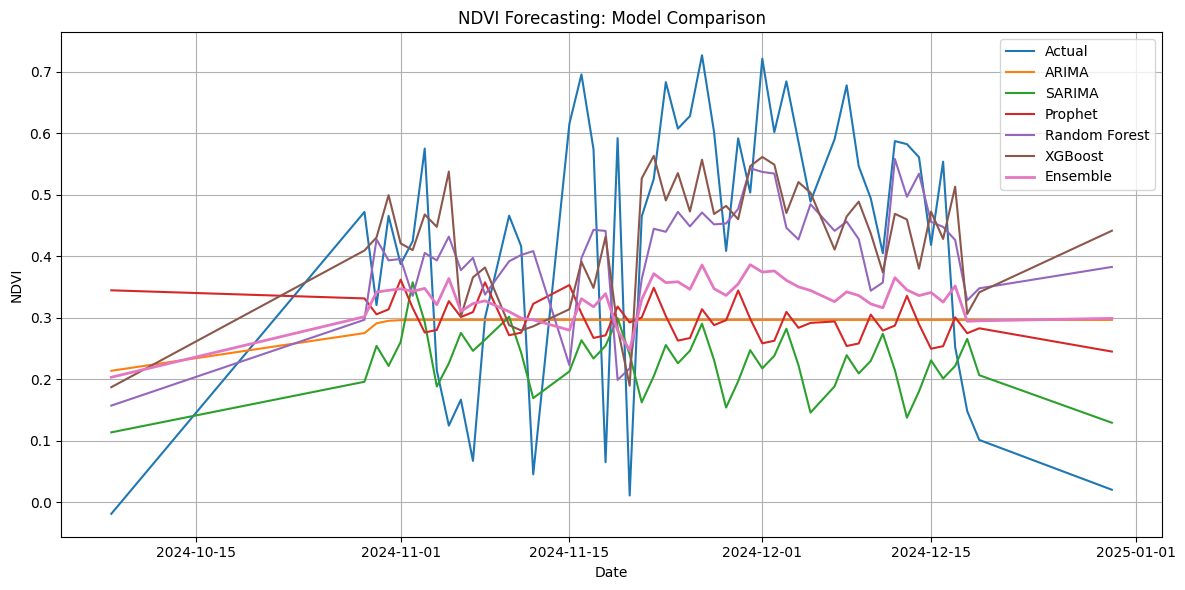

In [20]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_df.index[:min_length], test_df['ndvi'][:min_length], label='Actual')
plt.plot(test_df.index[:min_length], arima_pred[:min_length], label='ARIMA')
plt.plot(test_df.index[:min_length], sarima_pred[:min_length], label='SARIMA')
plt.plot(test_df.index[:min_length], prophet_pred[:min_length], label='Prophet')
plt.plot(test_df.index[:min_length], rf_pred[:min_length], label='Random Forest')
plt.plot(test_df.index[:min_length], xgb_pred[:min_length], label='XGBoost')
plt.plot(test_df.index[:min_length], ensemble_pred, label='Ensemble', linewidth=2)

plt.title('NDVI Forecasting: Model Comparison')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ndvi_model_comparison.png')


In [21]:
# Weighted ensemble based on individual model performance
# Calculate weights based on inverse RMSE (better models get higher weights)
arima_rmse = np.sqrt(mean_squared_error(test_df['ndvi'][:min_length], arima_pred[:min_length]))
sarima_rmse = np.sqrt(mean_squared_error(test_df['ndvi'][:min_length], sarima_pred[:min_length]))
prophet_rmse = np.sqrt(mean_squared_error(test_df['ndvi'][:min_length], prophet_pred[:min_length]))
rf_rmse = np.sqrt(mean_squared_error(test_df['ndvi'][:min_length], rf_pred[:min_length]))
xgb_rmse = np.sqrt(mean_squared_error(test_df['ndvi'][:min_length], xgb_pred[:min_length]))

# Calculate inverse RMSE
inv_rmse = [1/arima_rmse, 1/sarima_rmse, 1/prophet_rmse, 1/rf_rmse, 1/xgb_rmse]
weights = [w/sum(inv_rmse) for w in inv_rmse]

print("\nModel weights based on performance:")
model_names = ['ARIMA', 'SARIMA', 'Prophet', 'Random Forest', 'XGBoost']
for model, weight in zip(model_names, weights):
    print(f"{model}: {weight:.4f}")

# Weighted ensemble prediction
weighted_ensemble_pred = (
    weights[0] * arima_pred[:min_length] +
    weights[1] * sarima_pred[:min_length] +
    weights[2] * prophet_pred[:min_length] +
    weights[3] * rf_pred[:min_length] +
    weights[4] * xgb_pred[:min_length]
)

# Calculate weighted ensemble metrics
weighted_ensemble_rmse = np.sqrt(mean_squared_error(test_df['ndvi'][:min_length], weighted_ensemble_pred))
weighted_ensemble_mae = mean_absolute_error(test_df['ndvi'][:min_length], weighted_ensemble_pred)
weighted_ensemble_r2 = r2_score(test_df['ndvi'][:min_length], weighted_ensemble_pred)

print("\nWeighted Ensemble RMSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(
    weighted_ensemble_rmse, weighted_ensemble_mae, weighted_ensemble_r2))



Model weights based on performance:
ARIMA: 0.1816
SARIMA: 0.1560
Prophet: 0.1780
Random Forest: 0.2375
XGBoost: 0.2469

Weighted Ensemble RMSE: 0.2143, MAE: 0.1954, R²: -0.0080



Analyzing relationships between environmental variables and NDVI:

Correlations with NDVI:
ndvi             1.000000
wind_speed       0.211950
turbidity       -0.065211
tide_verified   -0.386969
Name: ndvi, dtype: float64


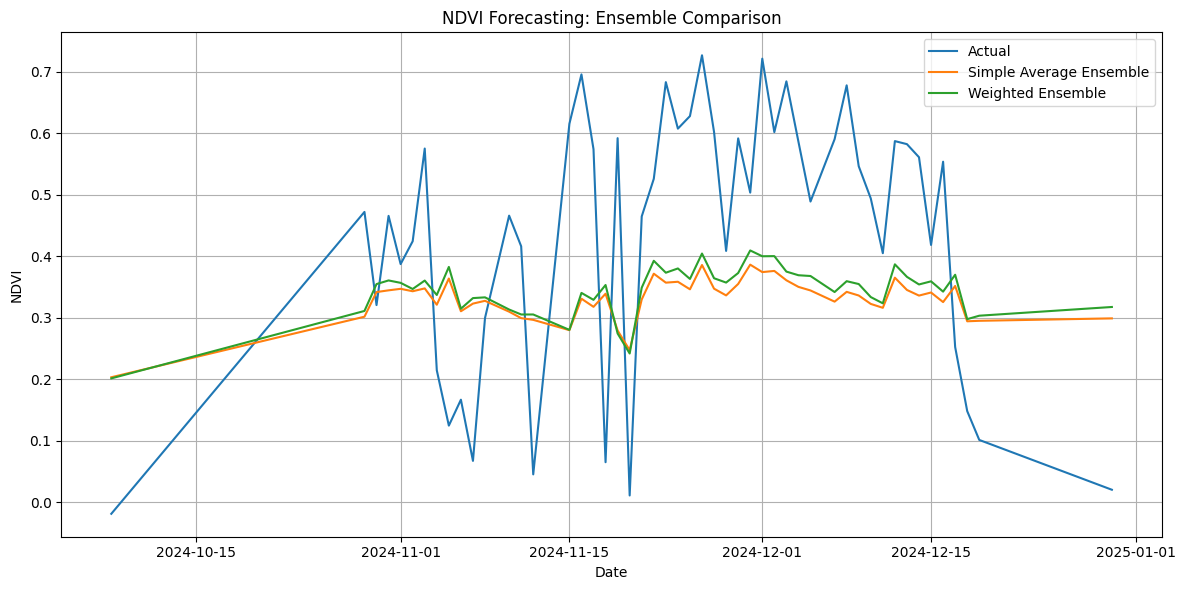

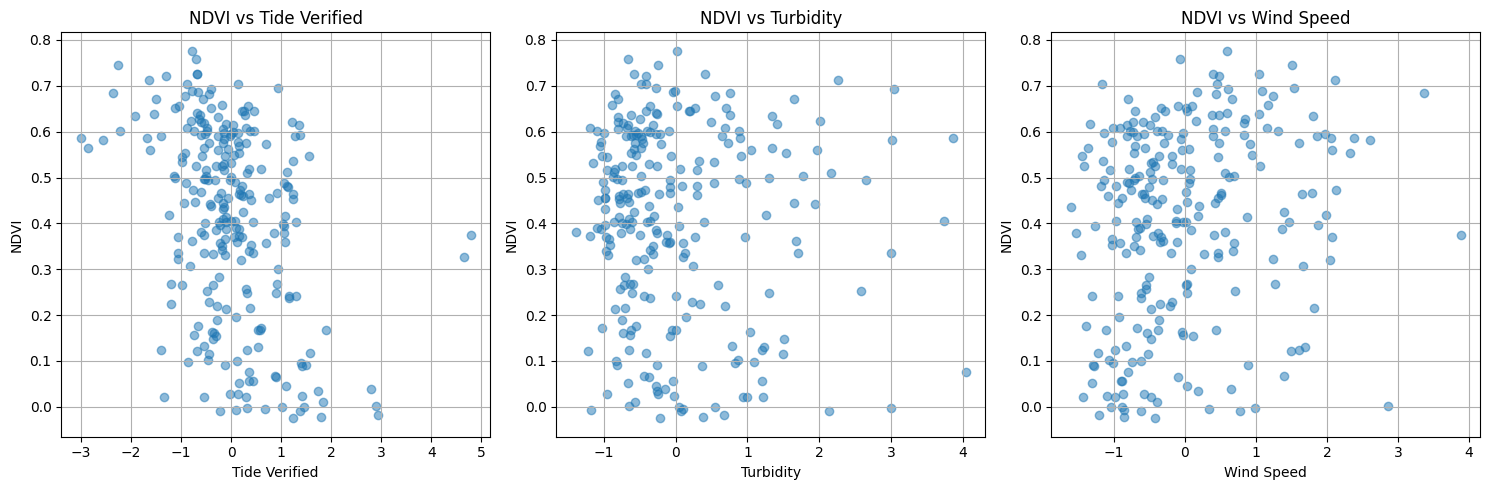

In [22]:
# Plot weighted ensemble comparison
plt.figure(figsize=(12, 6))
plt.plot(test_df.index[:min_length], test_df['ndvi'][:min_length], label='Actual')
plt.plot(test_df.index[:min_length], ensemble_pred, label='Simple Average Ensemble')
plt.plot(test_df.index[:min_length], weighted_ensemble_pred, label='Weighted Ensemble')

plt.title('NDVI Forecasting: Ensemble Comparison')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ndvi_ensemble_comparison.png')

# Identify which environmental variables are most predictive of NDVI
print("\nAnalyzing relationships between environmental variables and NDVI:")

# Calculate correlations
correlations = df[['tide_verified', 'turbidity', 'wind_speed', 'ndvi']].corr()['ndvi'].sort_values(ascending=False)
print("\nCorrelations with NDVI:")
print(correlations)

# Create scatter plots of environmental variables vs NDVI
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df['tide_verified'], df['ndvi'], alpha=0.5)
plt.title('NDVI vs Tide Verified')
plt.xlabel('Tide Verified')
plt.ylabel('NDVI')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(df['turbidity'], df['ndvi'], alpha=0.5)
plt.title('NDVI vs Turbidity')
plt.xlabel('Turbidity')
plt.ylabel('NDVI')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.scatter(df['wind_speed'], df['ndvi'], alpha=0.5)
plt.title('NDVI vs Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('NDVI')
plt.grid(True)

plt.tight_layout()
plt.savefig('ndvi_relationships.png')


In [23]:
# Summary of findings
print("\nSummary of NDVI prediction models:")
model_results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'Random Forest', 'XGBoost', 'Simple Ensemble', 'Weighted Ensemble'],
    'RMSE': [arima_rmse, sarima_rmse, prophet_rmse, rf_rmse, xgb_rmse, ensemble_rmse, weighted_ensemble_rmse],
    'MAE': [
        mean_absolute_error(test_df['ndvi'][:min_length], arima_pred[:min_length]),
        mean_absolute_error(test_df['ndvi'][:min_length], sarima_pred[:min_length]),
        mean_absolute_error(test_df['ndvi'][:min_length], prophet_pred[:min_length]),
        mean_absolute_error(test_df['ndvi'][:min_length], rf_pred[:min_length]),
        mean_absolute_error(test_df['ndvi'][:min_length], xgb_pred[:min_length]),
        ensemble_mae,
        weighted_ensemble_mae
    ],
    'R²': [
        r2_score(test_df['ndvi'][:min_length], arima_pred[:min_length]),
        r2_score(test_df['ndvi'][:min_length], sarima_pred[:min_length]),
        r2_score(test_df['ndvi'][:min_length], prophet_pred[:min_length]),
        r2_score(test_df['ndvi'][:min_length], rf_pred[:min_length]),
        r2_score(test_df['ndvi'][:min_length], xgb_pred[:min_length]),
        ensemble_r2,
        weighted_ensemble_r2
    ]
})

print(model_results.sort_values('RMSE'))



Summary of NDVI prediction models:
               Model      RMSE       MAE        R²
4            XGBoost  0.186019  0.155302  0.240808
3      Random Forest  0.193384  0.160851  0.179494
6  Weighted Ensemble  0.214345  0.195370 -0.008011
5    Simple Ensemble  0.222327  0.203599 -0.084482
0              ARIMA  0.252960  0.231618 -0.403916
2            Prophet  0.258057  0.234428 -0.461066
1             SARIMA  0.294470  0.263301 -0.902479


# Grid Search Cross Validation

In [24]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming df_scaled_with_lags is already prepared with features

# Set up features and target
features = [col for col in df.columns if col != 'ndvi']
X = df[features]
y = df['ndvi']

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# 1. Grid Search for XGBoost
print("Starting Grid Search for XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1]
}


xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

xgb_grid.fit(X, y)

print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best XGBoost RMSE: {-xgb_grid.best_score_:.4f}")

# 2. Grid Search for Random Forest
print("\nStarting Grid Search for Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None]
}
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X, y)

print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Random Forest RMSE: {-rf_grid.best_score_:.4f}")

# 3. Train optimal models on full training data
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

X_train = train_data[features]
y_train = train_data['ndvi']
X_test = test_data[features]
y_test = test_data['ndvi']

# Best XGBoost model
best_xgb = XGBRegressor(**xgb_grid.best_params_, random_state=42)
best_xgb.fit(X_train, y_train)
xgb_pred = best_xgb.predict(X_test)

# Best Random Forest model
best_rf = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
rf_pred = best_rf.predict(X_test)

# Calculate metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
rf_r2 = r2_score(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print("\nOptimized XGBoost on test data:")
print(f"RMSE: {xgb_rmse:.4f}, MAE: {xgb_mae:.4f}, R²: {xgb_r2:.4f}")

print("\nOptimized Random Forest on test data:")
print(f"RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")

# 4. Create optimized ensemble
# Weights based on CV performance
xgb_weight = -xgb_grid.best_score_ / (-xgb_grid.best_score_ + -rf_grid.best_score_)
rf_weight = -rf_grid.best_score_ / (-xgb_grid.best_score_ + -rf_grid.best_score_)

# Normalize weights
sum_weights = xgb_weight + rf_weight
xgb_weight = xgb_weight / sum_weights
rf_weight = rf_weight / sum_weights

print(f"\nOptimized weights - XGBoost: {xgb_weight:.4f}, Random Forest: {rf_weight:.4f}")

# Create ensemble predictions
ensemble_pred = (xgb_weight * xgb_pred) + (rf_weight * rf_pred)

# Calculate ensemble metrics
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print("\nGrid Search Optimized Ensemble:")
print(f"RMSE: {ensemble_rmse:.4f}, MAE: {ensemble_mae:.4f}, R²: {ensemble_r2:.4f}")

# 5. Feature importance from best models
xgb_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 features from optimized XGBoost:")
print(xgb_importance.head(10))

print("\nTop 10 features from optimized Random Forest:")
print(rf_importance.head(10))

# 6. Summary table
results = pd.DataFrame({
    'Model': ['XGBoost (Grid Search)', 'Random Forest (Grid Search)', 'Ensemble (Grid Search)'],
    'RMSE': [xgb_rmse, rf_rmse, ensemble_rmse],
    'MAE': [xgb_mae, rf_mae, ensemble_mae],
    'R²': [xgb_r2, rf_r2, ensemble_r2]
})

print("\nFinal performance comparison:")
print(results.sort_values('RMSE'))

Starting Grid Search for XGBoost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGBoost parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost RMSE: 0.1960

Starting Grid Search for Random Forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Random Forest parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest RMSE: 0.1963

Optimized XGBoost on test data:
RMSE: 0.1908, MAE: 0.1510, R²: 0.2011

Optimized Random Forest on test data:
RMSE: 0.1964, MAE: 0.1665, R²: 0.1534

Optimized weights - XGBoost: 0.4996, Random Forest: 0.5004

Grid Search Optimized Ensemble:
RMSE: 0.1912, MAE: 0.1583, R²: 0.1979

Top 10 features from optimized XGBoost:
                Feature  Importance
21     wind_speed_lag_5    0.061605
0         tide_verified    0.046761
6   

In [30]:
# Save best model
import pickle
with open('xgboost_ndvi_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

In [31]:
# Load the model
with open('xgboost_ndvi_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Random Forest and XGBoost

In [25]:
# XGBoost Model
def train_xgboost(train_data, test_data, params=None):
    # Default parameters
    if params is None:
        params = {
            'n_estimators': 100,
            'learning_rate': 0.05,
            'max_depth': 3,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'random_state': 42
        }

    # Features and target
    features = [col for col in train_data.columns if col != 'ndvi']
    X_train = train_data[features]
    y_train = train_data['ndvi']
    X_test = test_data[features]

    # Train model
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data['ndvi'], predictions))
    mae = mean_absolute_error(test_data['ndvi'], predictions)
    r2 = r2_score(test_data['ndvi'], predictions)

    print(f"XGBoost RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 important features for XGBoost:")
    print(feature_importance.head(10))

    return predictions, model, feature_importance


In [26]:
# Random Forest Model
def train_rf(train_data, test_data, params=None):
    # Default parameters
    if params is None:
        params = {
            'n_estimators': 200,
            'max_depth': 10,
            'min_samples_split': 5,
            'min_samples_leaf': 1,
            'max_features': 'sqrt',
            'random_state': 42
        }

    # Features and target
    features = [col for col in train_data.columns if col != 'ndvi']
    X_train = train_data[features]
    y_train = train_data['ndvi']
    X_test = test_data[features]

    # Train model
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test_data['ndvi'], predictions))
    mae = mean_absolute_error(test_data['ndvi'], predictions)
    r2 = r2_score(test_data['ndvi'], predictions)

    print(f"Random Forest RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 important features for Random Forest:")
    print(feature_importance.head(10))

    return predictions, model, feature_importance


Training optimized XGBoost model...
XGBoost RMSE: 0.1908, MAE: 0.1510, R²: 0.2011

Top 10 important features for XGBoost:
                Feature  Importance
21     wind_speed_lag_5    0.061605
0         tide_verified    0.046761
6            ndvi_lag_1    0.046647
26           ndvi_lag_6    0.044196
22           ndvi_lag_5    0.040444
23  tide_verified_lag_6    0.040434
15  tide_verified_lag_4    0.039938
25     wind_speed_lag_6    0.035728
20      turbidity_lag_5    0.035413
11  tide_verified_lag_3    0.034985

Training optimized Random Forest model...
Random Forest RMSE: 0.1964, MAE: 0.1665, R²: 0.1534

Top 10 important features for Random Forest:
                Feature  Importance
0         tide_verified    0.083774
6            ndvi_lag_1    0.074863
23  tide_verified_lag_6    0.054824
21     wind_speed_lag_5    0.050138
11  tide_verified_lag_3    0.045017
15  tide_verified_lag_4    0.041250
3   tide_verified_lag_1    0.039097
19  tide_verified_lag_5    0.038560
17     wind_speed

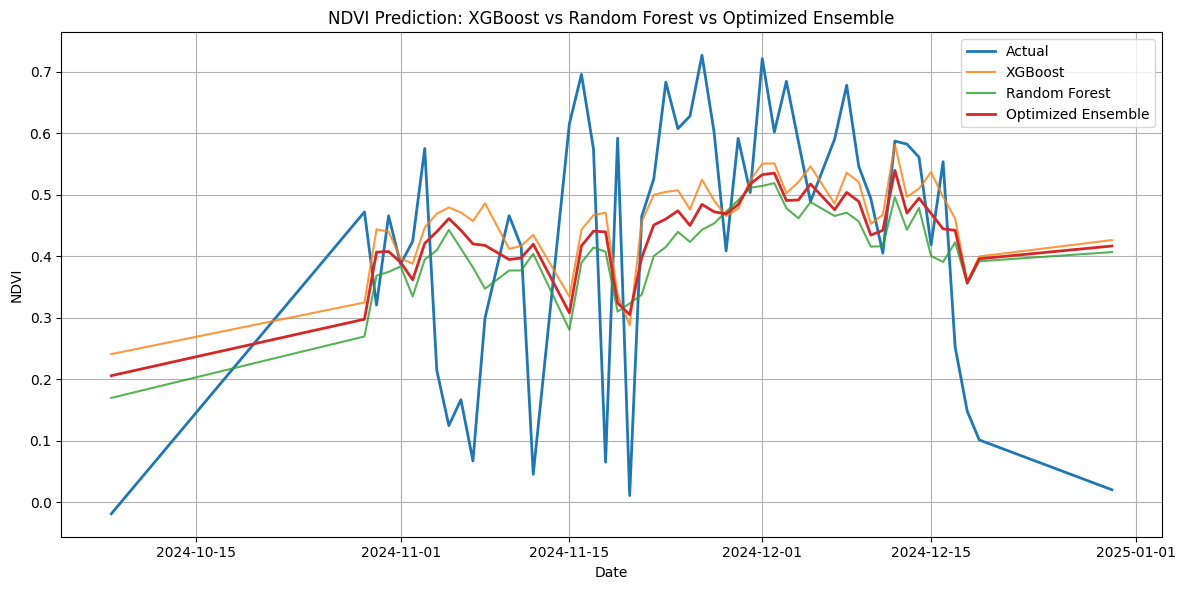

<Figure size 1000x800 with 0 Axes>

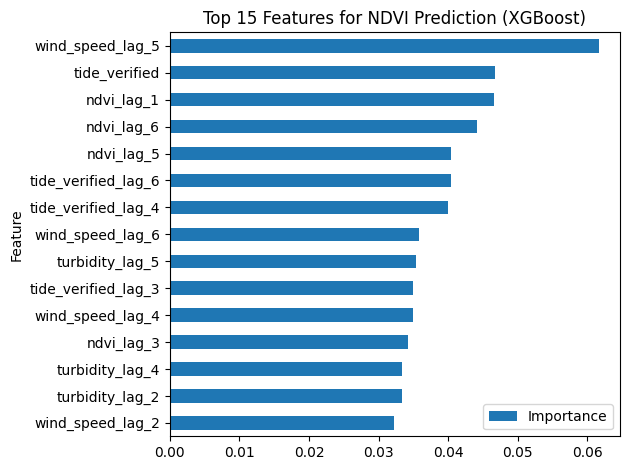

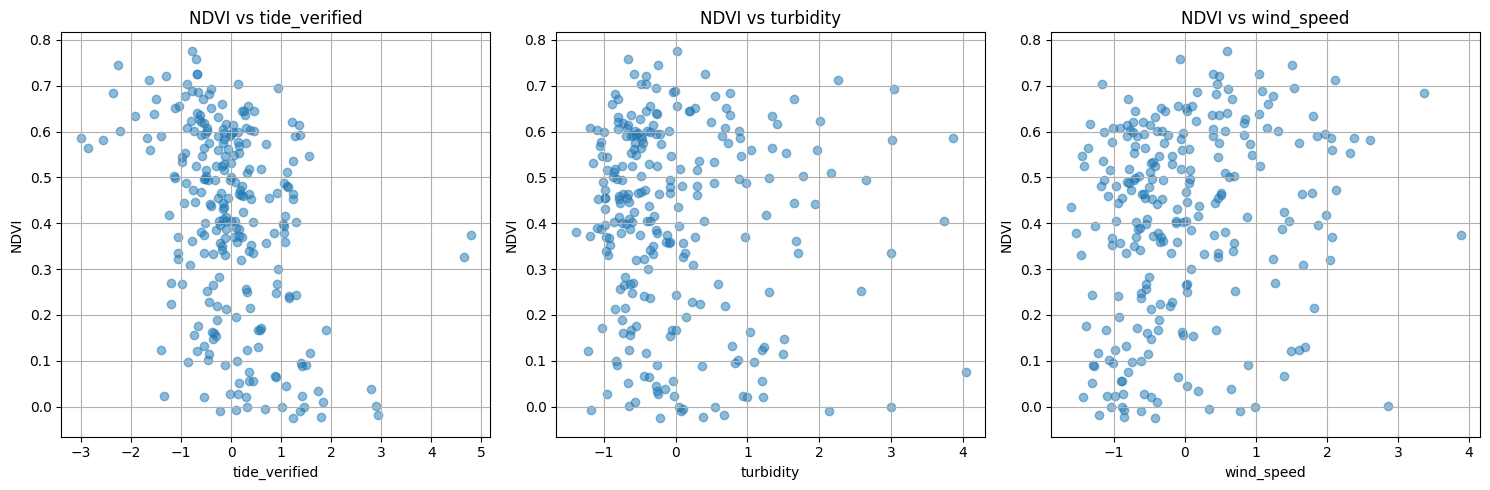

In [28]:
# Train optimized XGBoost model with hyperparameters
xgb_params = {
        'n_estimators': 100,
        'learning_rate': 0.05,
        'max_depth': 3,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'random_state': 42
    }

print("Training optimized XGBoost model...")
xgb_pred, xgb_model, xgb_importance = train_xgboost(train_with_lags, test_with_lags, xgb_params)

# Train optimized Random Forest model
rf_params = {
        'n_estimators': 200,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'random_state': 42
    }

print("\nTraining optimized Random Forest model...")
rf_pred, rf_model, rf_importance = train_rf(train_with_lags, test_with_lags, rf_params)

# Create RF + XGB ensemble (optimized weighting based on performance)
xgb_rmse = np.sqrt(mean_squared_error(test_with_lags['ndvi'], xgb_pred))
rf_rmse = np.sqrt(mean_squared_error(test_with_lags['ndvi'], rf_pred))

# Calculate weights inversely proportional to RMSE
inv_rmse = [1/rf_rmse, 1/xgb_rmse]
weights = [w/sum(inv_rmse) for w in inv_rmse]

print("\nModel weights for optimized ensemble:")
print(f"Random Forest: {weights[0]:.4f}")
print(f"XGBoost: {weights[1]:.4f}")

# Create optimized ensemble predictions
optimized_ensemble_pred = weights[0] * rf_pred + weights[1] * xgb_pred

# Calculate ensemble metrics
ensemble_rmse = np.sqrt(mean_squared_error(test_with_lags['ndvi'], optimized_ensemble_pred))
ensemble_mae = mean_absolute_error(test_with_lags['ndvi'], optimized_ensemble_pred)
ensemble_r2 = r2_score(test_with_lags['ndvi'], optimized_ensemble_pred)

print(f"\nOptimized Ensemble RMSE: {ensemble_rmse:.4f}, MAE: {ensemble_mae:.4f}, R²: {ensemble_r2:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_with_lags.index, test_with_lags['ndvi'], label='Actual', linewidth=2)
plt.plot(test_with_lags.index, xgb_pred, label='XGBoost', alpha=0.8)
plt.plot(test_with_lags.index, rf_pred, label='Random Forest', alpha=0.8)
plt.plot(test_with_lags.index, optimized_ensemble_pred, label='Optimized Ensemble', linewidth=2)

plt.title('NDVI Prediction: XGBoost vs Random Forest vs Optimized Ensemble')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('optimized_ndvi_prediction.png')

# Feature importance visualization for the best model (XGBoost)
plt.figure(figsize=(10, 8))
xgb_importance.head(15).sort_values('Importance').plot(kind='barh', x='Feature', y='Importance')
plt.title('Top 15 Features for NDVI Prediction (XGBoost)')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')

# Summary results table
results = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'Optimized Ensemble'],
    'RMSE': [xgb_rmse, rf_rmse, ensemble_rmse],
    'MAE': [
        mean_absolute_error(test_with_lags['ndvi'], xgb_pred),
        mean_absolute_error(test_with_lags['ndvi'], rf_pred),
        ensemble_mae
    ],
    'R²': [
        r2_score(test_with_lags['ndvi'], xgb_pred),
        r2_score(test_with_lags['ndvi'], rf_pred),
        ensemble_r2
    ]
})

print("\nSummary of model performance:")
print(results.sort_values('RMSE'))

# Analyze relationship between NDVI and environmental variables
print("\nCorrelation between NDVI and environmental variables:")
correlations = df[['ndvi', 'tide_verified', 'turbidity', 'wind_speed']].corr()['ndvi'].sort_values(ascending=False)
print(correlations)

# Create scatterplots of NDVI vs top predictors
top_features = xgb_importance['Feature'].head(3).tolist()
print(f"\nScatterplots saved for NDVI vs top predictors: {top_features}")

plt.figure(figsize=(15, 5))
for i, feature in enumerate(['tide_verified', 'turbidity', 'wind_speed']):
    plt.subplot(1, 3, i+1)
    plt.scatter(df[feature], df['ndvi'], alpha=0.5)
    plt.title(f'NDVI vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('NDVI')
    plt.grid(True)

plt.tight_layout()
plt.savefig('ndvi_vs_predictors.png')
